In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential, clone_model, load_model
from keras.layers import LSTM, Dense, Reshape
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

2023-06-28 09:39:22.349591: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 09:39:22.622034: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 09:39:22.625064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 09:39:25.542678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv("datasets/processed_data_with_stages.csv")
df = df.rename(columns={"Unnamed: 0":"Timestamp"})

In [4]:
STAGES_LENGTH = 150
N_STAGES = len(df)/STAGES_LENGTH

In [21]:
def generate_cross_validation_sets(df, K, iteration):
    train_df = pd.DataFrame(columns=["DAC","Frequency Error","Phase Error","Temperature"])
    val_df = pd.DataFrame(columns=["DAC","Frequency Error","Phase Error","Temperature"])
    test_df = pd.DataFrame(columns=["DAC","Frequency Error","Phase Error","Temperature"])

    for i in range(0,int(N_STAGES/K)):
        if i==iteration:
            test_df = test_df.append(df[K*i*STAGES_LENGTH:(K*i+K)*STAGES_LENGTH], ignore_index=True)
        elif i == (iteration+1)%N_STAGES:
            val_df = val_df.append(df[K*i*STAGES_LENGTH:(K*i+K)*STAGES_LENGTH], ignore_index=True)
        else:
            train_df = train_df.append(df[K*i*STAGES_LENGTH:(K*i+K)*STAGES_LENGTH], ignore_index=True)

    return train_df, val_df, test_df

def normalize_datasets(train_df, val_df, test_df):
    train_mean = train_df.drop("Timestamp",axis=1).mean()
    train_std = train_df.drop("Timestamp",axis=1).std()

    train_df = (train_df.drop("Timestamp",axis=1) - train_mean) / train_std
    val_df = (val_df.drop("Timestamp",axis=1) - train_mean) / train_std
    test_df = (test_df.drop("Timestamp",axis=1) - train_mean) / train_std
    
    return train_df, val_df, test_df, train_mean, train_std

def generate_moving_windows(df, feature_to_predict, stages_length, input_size, output_size):
    input_windows = []
    output_windows = []

    # Obtener las ventanas deslizantes
    for stage in range(int(len(df)/stages_length)):
        for i in range(0, int((stages_length - input_size - output_size))):
            input_window = df[stage*stages_length+i:stage*stages_length+i+input_size]
            output_window = df[stage*stages_length+i+input_size:stage*stages_length+i+input_size+output_size][feature_to_predict]
            input_windows.append(input_window)
            output_windows.append(output_window)
            #if i>135 and i<150:
                #print(i)

    # Convertir las listas a arreglos NumPy
    input_windows = np.array(input_windows)
    output_windows = np.array(output_windows)
    output_windows = output_windows.reshape(output_windows.shape[0],output_windows.shape[1],1)

    # Verificar las dimensiones de los arreglos
    print("Dimensiones de las ventanas de entrada:", input_windows.shape)
    print("Dimensiones de las ventanas de salida:", output_windows.shape)
    return input_windows, output_windows

def generate_test_moving_windows(df, feature_to_predict, stages_length, input_size, output_size):
    input_windows = []
    output_windows = []

    # Obtener las ventanas deslizantes
    for stage in range(int(len(df)/stages_length)):
        for i in range(0, int((stages_length - input_size)/output_size)):
            input_window = df[stage*stages_length+i*output_size:stage*stages_length+i*output_size+input_size]
            output_window = df[stage*stages_length+i*output_size+input_size:stage*stages_length+i*output_size+input_size+output_size][feature_to_predict]
            input_windows.append(input_window)
            output_windows.append(output_window)
            #if i>135 and i<150:
                #print(i)

    # Convertir las listas a arreglos NumPy
    input_windows = np.array(input_windows)
    output_windows = np.array(output_windows)
    output_windows = output_windows.reshape(output_windows.shape[0],output_windows.shape[1],1)

    # Verificar las dimensiones de los arreglos
    print("Dimensiones de las ventanas de entrada:", input_windows.shape)
    print("Dimensiones de las ventanas de salida:", output_windows.shape)
    return input_windows, output_windows

def train_model(X_train, y_train, X_val, y_val, output_size, deep_layers, lstm_units, lr, bs, epochs):
    model = Sequential()
    
    for i in range(deep_layers):
        model.add(LSTM(lstm_units, return_sequences=True))
    
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dense(output_size, activation="linear", kernel_initializer=tf.initializers.zeros()))
    

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=20,
                                                    mode='min')
    
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(X_train,y_train, epochs=epochs, batch_size=bs,
                      validation_data=(X_val,y_val),
                      callbacks=[early_stopping, rlrop],verbose=0)
    return history, model

def get_metrics(test,pred, print_results=True):
    mae = mean_absolute_error(test, pred)
    mse = mean_squared_error(test, pred)
    if print_results:
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE: ', np.sqrt(mse))
    return mae, np.sqrt(mse)

def cross_validation_tuning(df, K, input_size, output_size, layers, lstm_units, lr, bs, epochs):
    predictions=[]
    mae_vector, rmse_vector = np.array([]), np.array([])
    
    for fold in range(0, int(N_STAGES/K)-1):
        train_df, val_df, test_df = generate_cross_validation_sets(df, K, fold)
        train_df, val_df, test_df, train_mean, train_std = normalize_datasets(train_df, val_df, test_df)
        X_train, y_train = generate_moving_windows(train_df, "DAC",150,input_size,output_size)
        X_val, y_val = generate_moving_windows(val_df, "DAC",150,input_size,output_size)
        X_test, y_test = generate_test_moving_windows(test_df, "DAC",150,input_size,output_size)
        history, model = train_model(X_train, y_train, X_val, y_val, 
                                    deep_layers=layers, output_size=output_size, lstm_units=lstm_units,
                                    lr=lr, bs=bs, epochs=epochs)
        results = model.predict(X_test, verbose=0).reshape(y_test.shape[0],y_test.shape[1],1)
        res = pd.Series(results.flatten())
        mae, rmse = get_metrics(y_test.flatten(), results.flatten(), False)
        mae_vector = np.append(mae_vector,mae)
        rmse_vector = np.append(rmse_vector,rmse)
        predictions.append(res)
        
        
    all_stages = []
    mean = df["DAC"].values.mean()
    std_dev = df["DAC"].values.std()
    normalized = (df["DAC"].values-mean)/std_dev
    for i in range(int(N_STAGES)):
        aux=pd.Series(normalized[i*STAGES_LENGTH:(i+1)*STAGES_LENGTH])
        all_stages.append(aux)
    stages_mean = pd.concat(all_stages,axis=1).mean(axis=1)

    mae = mae_vector.mean()
    rmse = rmse_vector.mean()

    return predictions, stages_mean, mae, rmse

def tuning(results_df, train_df, val_df, test_df, input_size, output_size, layers, lstm_units, lr, bs, epochs):
    best_mae = 100.0
    for deep in layers:
        for units in lstm_units:
            for learning in lr:
                for batch in bs:
                    X_train, y_train = generate_moving_windows(train_df, "DAC",150,input_size,output_size)
                    X_val, y_val = generate_moving_windows(val_df, "DAC",150,input_size,output_size)
                    X_test, y_test = generate_moving_windows(test_df, "DAC",150,input_size,output_size)
                    history, model = train_model(X_train, y_train, X_val, y_val, output_size=output_size,
                                                 deep_layers=deep, lstm_units=units, lr=learning, bs=batch, epochs=epochs)
                    results = model.predict(X_test, verbose=0).reshape(y_test.shape[0],y_test.shape[1],1)
                    mae, rmse = get_metrics(y_test.flatten(), results.flatten(), False)
                    if mae<best_mae:
                        best_mae=mae
                        best_model = clone_model(model)
                        best_model.set_weights(model.get_weights())
                    aux = pd.Series([input_size,output_size,mae,rmse,deep,units,learning,batch,epochs],index=results_df.columns)
                    results_df = results_df.append(aux,ignore_index=True)
                    #out = "\n".join([
                    #    f"Deep={deep}, Steps={steps}, LSTM_units={units}, Learning_Rate={learning}, Batch_Size={batch}, Max_Epochs={epochs}",
                    #    f"MAE:{mae}",
                    #    f"RMSE:{rmse}",
                    #    "----------------------------------------"
                    #])
                    #print(out)
                    #reset_weights(model)
    return results_df, best_model

## Input = 20, Output = 1

In [27]:
INPUT_SIZE=20
OUTPUT_SIZE=1

In [7]:
#preds_20_1 = pd.DataFrame(columns=["input_size","output_size","mae","rmse","deep_layers","lstm_units","learning_rate","batch_size","max_epochs"])
preds_20_1 = pd.read_csv("datasets/predictions_input20_output1.csv")

In [8]:
preds_20_1.sort_values(by="mae",ascending=True).head(20)

,input_size,output_size,mae,rmse,deep_layers,lstm_units,learning_rate,batch_size,max_epochs
63,20.0,1.0,0.058718,0.110545,0.0,160.0,0.010,1.0,300.0
27,20.0,1.0,0.060749,0.111386,0.0,80.0,0.010,1.0,300.0
42,20.0,1.0,0.061617,0.106597,0.0,100.0,0.005,1.0,300.0
20,20.0,1.0,0.062245,0.106922,0.0,60.0,0.005,4.0,300.0
5,20.0,1.0,0.062720,0.109896,0.0,40.0,0.010,4.0,300.0
39,20.0,1.0,0.062867,0.105167,0.0,100.0,0.010,1.0,300.0
7,20.0,1.0,0.062914,0.106380,0.0,40.0,0.005,2.0,300.0
8,20.0,1.0,0.063217,0.102843,0.0,40.0,0.005,4.0,300.0
62,20.0,1.0,0.063295,0.113470,0.0,160.0,0.050,4.0,300.0
16,20.0,1.0,0.063344,0.104546,0.0,60.0,0.010,2.0,300.0


In [7]:
cross_val_preds, stages_mean, mae, rmse = cross_validation_tuning(df, 1, INPUT_SIZE, OUTPUT_SIZE, 0, 160, 0.01, 1, 300)


Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 09:39:40.182946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 09:39:40.189128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 09:39:40.193591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 09:56:42.759371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 09:56:42.762293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 09:56:42.766102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 10:31:55.734904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 10:31:55.741283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 10:31:55.747837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 11:06:55.940268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 11:06:55.943563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 11:06:55.951006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 11:41:40.979137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 11:41:40.981435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 11:41:40.982823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 12:01:52.054280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 12:01:52.057019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 12:01:52.059351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 12:24:43.722345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 12:24:43.725225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 12:24:43.727019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 12:44:23.246442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 12:44:23.251204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 12:44:23.254530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 12:55:55.252703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 12:55:55.255174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 12:55:55.258548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 13:11:44.376133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 13:11:44.380683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 13:11:44.383227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 13:29:31.142551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 13:29:31.147035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 13:29:31.149356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 13:39:37.928163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 13:39:37.930861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 13:39:37.932907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 13:55:12.569663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 13:55:12.571900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 13:55:12.573814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 14:10:59.725464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 14:10:59.727667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 14:10:59.729586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 14:25:48.571606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 14:25:48.573622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 14:25:48.575015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 14:47:12.691354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 14:47:12.694227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 14:47:12.696284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 15:00:00.201318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 15:00:00.203461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 15:00:00.205124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 15:13:11.020703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 15:13:11.023414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 15:13:11.025294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 15:28:42.552101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 15:28:42.555336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 15:28:42.557567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 15:43:48.626096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 15:43:48.629056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 15:43:48.631223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2600, 20, 4)
Dimensiones de las ventanas de salida: (2600, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)
Dimensiones de las ventanas de entrada: (130, 20, 4)
Dimensiones de las ventanas de salida: (130, 1, 1)


2023-06-28 15:57:42.642398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 15:57:42.644439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 15:57:42.647180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [30]:
series = []
series1 = np.array(cross_val_preds)
print(series1.shape)
media = np.mean(series1, axis=0)
std_dev = np.std(series1, axis=0)
mae, rmse = get_metrics(stages_mean[INPUT_SIZE:], media, False)

(21, 130)


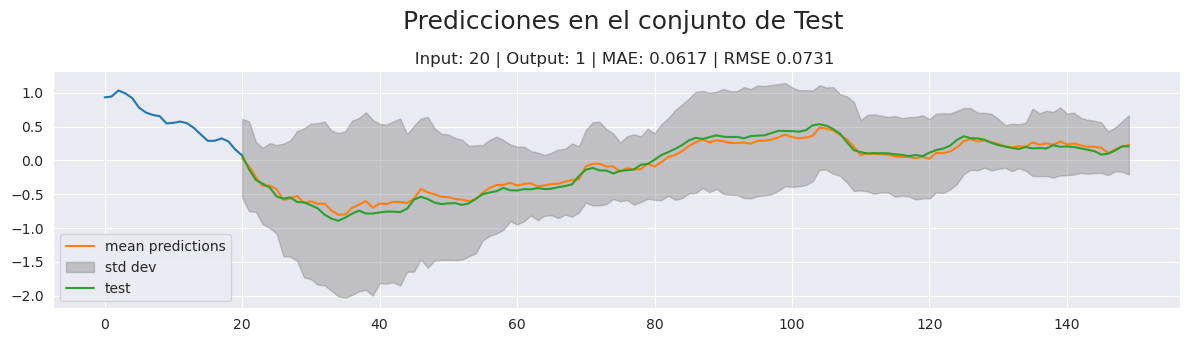

In [31]:
INPUT_SIZE = 20
OUTPUT_SIZE = 1

plt.figure(figsize=(12,6))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.subplot(2, 1, 1)

plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae.round(4))} | RMSE {str(rmse.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media - std_dev, media + std_dev, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp20out1.png")

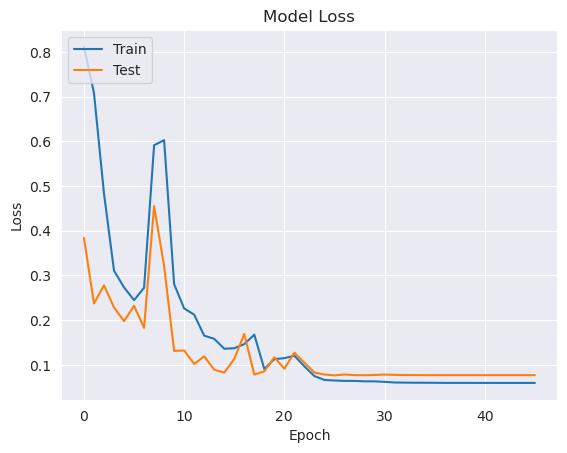

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Input = 20, Output = 5

In [ ]:
#preds_20_5 = pd.DataFrame(columns=["input_size","output_size","mae","rmse","deep_layers","lstm_units","learning_rate","batch_size","max_epochs"])
preds_20_5 = pd.read_csv("datasets/predictions_input20_output5.csv")

In [ ]:
preds_20_5.to_csv("datasets/predictions_input20_output5.csv",index=False)

In [8]:
INPUT_SIZE=20
OUTPUT_SIZE=5
cross_val_preds_20_5, stages_mean_20_5, mae_20_5, rmse_20_5 = cross_validation_tuning(df, 1, 20, 5, 0, 160, 0.01, 1, 300)


Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:11:50.990937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:11:50.994439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:11:50.996584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:13:33.379011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:13:33.381530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:13:33.384552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:15:57.517013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:15:57.519261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:15:57.522158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-28 16:17:47.890304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:17:47.892198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:17:47.893780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:17:48.561500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:17:48.563461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:17:48.564839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-28 16:19:34.837199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:19:34.839629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:19:34.841648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:19:35.505786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:19:35.507998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:19:35.509509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:22:12.743945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:22:12.746035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:22:12.747660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:24:23.567880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:24:23.569722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:24:23.571075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:26:57.104998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:26:57.106792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:26:57.108222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:29:48.963237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:29:48.965346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:29:48.967002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:32:58.624204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:32:58.627712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:32:58.629960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:35:33.264731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:35:33.267973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:35:33.270571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:38:02.874474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:38:02.877043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:38:02.878754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:40:07.784525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:40:07.786647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:40:07.788476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:42:17.733133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:42:17.735227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:42:17.736692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:45:35.194945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:45:35.198406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:45:35.200505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:47:35.382634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:47:35.384797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:47:35.386713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:49:26.619663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:49:26.622779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:49:26.624985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:51:46.582137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:51:46.584052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:51:46.585728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:54:01.224788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:54:01.227446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:54:01.230171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:56:10.805346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:56:10.807250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:56:10.808706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (520, 20, 4)
Dimensiones de las ventanas de salida: (520, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 16:58:20.902027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 16:58:20.904225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 16:58:20.905692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [32]:
INPUT_SIZE=20
OUTPUT_SIZE=5
series1 = np.array(cross_val_preds_20_5)
print(series1.shape)
media5 = np.mean(series1, axis=0)
std_dev5 = np.std(series1, axis=0)
mae_5, rmse_5 = get_metrics(stages_mean[INPUT_SIZE:], media5, False)

(21, 130)


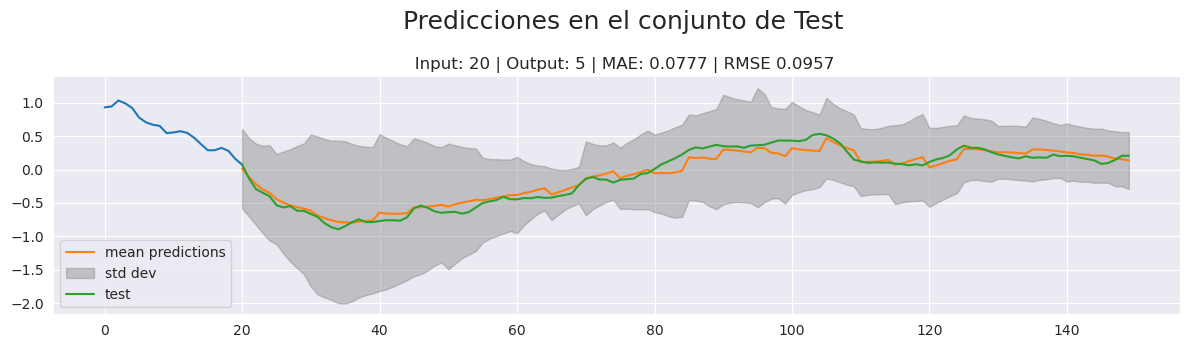

In [24]:
INPUT_SIZE = 20
OUTPUT_SIZE = 5

plt.figure(figsize=(12,3.5))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)


plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_20_5.round(4))} | RMSE {str(rmse_20_5.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media - std_dev, media + std_dev, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp20out5.png")

In [22]:
INPUT_SIZE=20
OUTPUT_SIZE=5
cross_val_preds_20_5, stages_mean_20_5, mae_20_5, rmse_20_5 = cross_validation_tuning(df, 1, 20, 5, 0, 160, 0.01, 1, 300)

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 18:56:53.647120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 18:56:53.649207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 18:56:53.650747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 19:13:55.066026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 19:13:55.069570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 19:13:55.071867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 19:28:51.104853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 19:28:51.107579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 19:28:51.109664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 19:36:33.107023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 19:36:33.109170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 19:36:33.110855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 19:44:47.767363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 19:44:47.769408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 19:44:47.772169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 19:53:15.229855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 19:53:15.233559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 19:53:15.236019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 20:08:24.297410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 20:08:24.299276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 20:08:24.301358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 20:24:38.886515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 20:24:38.888156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 20:24:38.890680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 20:36:41.557732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 20:36:41.559977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 20:36:41.561933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 20:47:57.520378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 20:47:57.524180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 20:47:57.526934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 21:00:25.906666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:00:25.910788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:00:25.913241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 21:08:57.138671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:08:57.144784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:08:57.159788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 21:20:37.578620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:20:37.580807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:20:37.582526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 21:32:11.666390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:32:11.670138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:32:11.672892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 21:43:18.789678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:43:18.792376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:43:18.794351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 21:57:48.054396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 21:57:48.056287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 21:57:48.057907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 22:08:00.974625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 22:08:00.978305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 22:08:00.980893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 22:17:40.021922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 22:17:40.025837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 22:17:40.028063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 22:32:26.545536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 22:32:26.548080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 22:32:26.549887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 22:47:07.113655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 22:47:07.116885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 22:47:07.119556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2500, 20, 4)
Dimensiones de las ventanas de salida: (2500, 5, 1)
Dimensiones de las ventanas de entrada: (125, 20, 4)
Dimensiones de las ventanas de salida: (125, 5, 1)
Dimensiones de las ventanas de entrada: (26, 20, 4)
Dimensiones de las ventanas de salida: (26, 5, 1)


2023-06-28 22:56:22.122678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 22:56:22.125549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 22:56:22.127354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
preds_20_5.sort_values(by="mae",ascending=True).head(20)

,input_size,output_size,mae,rmse,deep_layers,lstm_units,learning_rate,batch_size,max_epochs
153,20.0,5.0,0.162086,0.237612,1.0,160.0,0.010,4.0,300.0
24,20.0,5.0,0.165304,0.245987,0.0,100.0,0.050,1.0,300.0
186,20.0,5.0,0.166026,0.239662,2.0,120.0,0.005,2.0,300.0
80,20.0,5.0,0.166096,0.241567,1.0,100.0,0.005,4.0,300.0
146,20.0,5.0,0.166556,0.251542,1.0,140.0,0.005,2.0,300.0
148,20.0,5.0,0.167477,0.235679,1.0,140.0,0.001,2.0,300.0
166,20.0,5.0,0.167745,0.243121,2.0,60.0,0.010,2.0,300.0
113,20.0,5.0,0.168486,0.245600,0.0,140.0,0.010,4.0,300.0
61,20.0,5.0,0.169106,0.241529,1.0,80.0,0.050,2.0,300.0
37,20.0,5.0,0.169902,0.251989,0.0,120.0,0.050,2.0,300.0


In [ ]:
preds_20_5 = tuning(preds_20_5, train_df, val_df, test_df, input_size=20, output_size=5, layers=[2], lstm_units=[40,60,80,100,120], lr=[0.01, 0.005, 0.001], bs=[2,4], epochs=300)
# HECHO

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:27:48.936324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:27:48.938405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:27:48.939907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:30:07.475769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:30:07.478266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:30:07.479940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:31:43.234659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:31:43.236582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:31:43.240184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:33:40.647021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:33:40.649989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:33:40.651866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


/tmp/ipykernel_2324/3144536155.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(aux,ignore_index=True)
2023-06-05 15:35:04.072040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:35:04.074972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


/tmp/ipykernel_2324/3144536155.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(aux,ignore_index=True)
2023-06-05 15:38:22.358988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:38:22.361123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:39:47.129626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:39:47.131853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:39:47.133769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:42:56.821858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:42:56.824150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:42:56.826528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:44:21.914294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:44:21.917197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:44:21.919201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:46:44.009040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:46:44.012078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:46:44.014404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:48:24.646287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:48:24.648465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:48:24.650609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:52:01.040223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:52:01.042986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:52:01.045063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:53:49.315948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:53:49.318779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:53:49.320957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:56:58.586712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:56:58.590197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:56:58.592177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 15:58:41.220717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 15:58:41.223143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 15:58:41.225071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:02:02.771534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:02:02.774623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:02:02.776550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:03:34.357027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:03:34.361655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:03:34.363581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:06:54.871226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:06:54.873803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:06:54.875505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:08:54.324999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:08:54.327424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:08:54.329911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:12:04.211923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:12:04.214087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:12:04.216348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:14:41.492217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:14:41.495176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:14:41.497259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:17:54.969517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:17:54.972024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:17:54.973459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:19:21.994414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:19:21.996457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:19:21.998180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:22:45.081587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:22:45.084392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:22:45.086636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:25:15.413220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:25:15.416032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:25:15.418079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:27:56.820776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:27:56.822847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:27:56.824600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:30:26.427988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:30:26.430442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:30:26.431796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:33:51.556620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:33:51.559451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:33:51.562042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:36:00.643369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:36:00.646429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:36:00.648701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (416, 20, 4)
Dimensiones de las ventanas de salida: (416, 5, 1)
Dimensiones de las ventanas de entrada: (104, 20, 4)
Dimensiones de las ventanas de salida: (104, 5, 1)
Dimensiones de las ventanas de entrada: (52, 20, 4)
Dimensiones de las ventanas de salida: (52, 5, 1)


2023-06-05 16:40:44.241999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 16:40:44.243924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 16:40:44.245741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

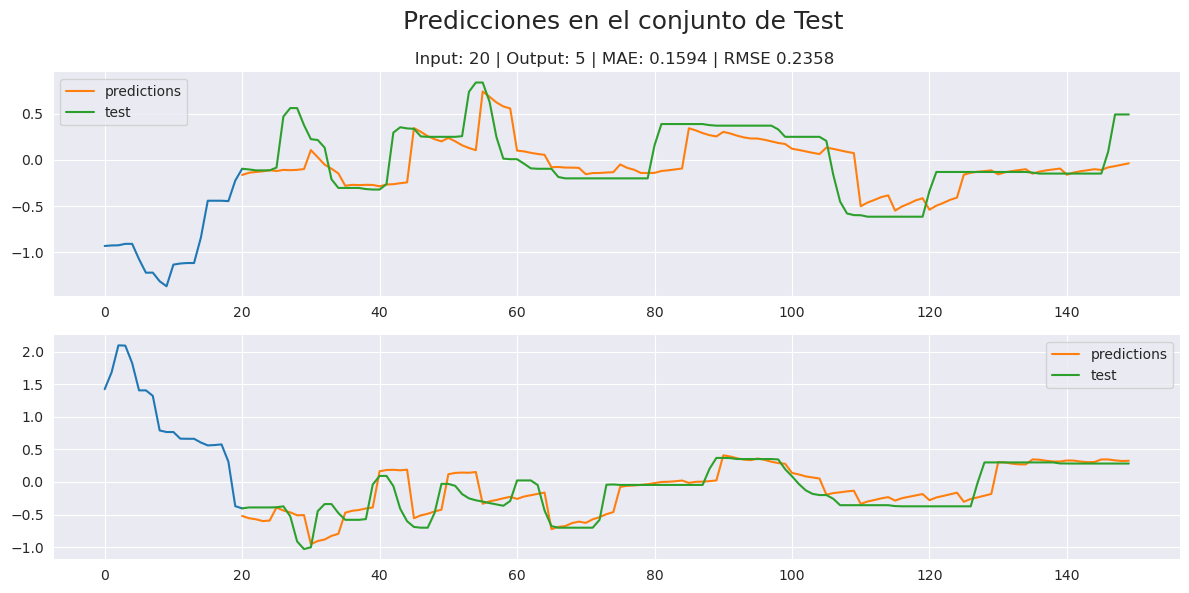

In [ ]:
INPUT_SIZE = 20
OUTPUT_SIZE = 5

plt.figure(figsize=(12,6))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.subplot(2, 1, 1)

plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae.round(4))} | RMSE {str(rmse.round(4))}")
res = results[1].reshape(results.shape[1])
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(test_df[:INPUT_SIZE+1]["DAC"].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(results.flatten()[:STAGES_LENGTH-INPUT_SIZE]), label="predictions")
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(test_df[INPUT_SIZE:STAGES_LENGTH]["DAC"].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.subplot(2, 1, 2)

res = results[0].reshape(results.shape[1])
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(test_df[STAGES_LENGTH:STAGES_LENGTH+INPUT_SIZE+1]["DAC"].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(results.flatten()[STAGES_LENGTH-INPUT_SIZE:2*STAGES_LENGTH-2*INPUT_SIZE]), label="predictions")
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(test_df[STAGES_LENGTH+INPUT_SIZE:2*STAGES_LENGTH]["DAC"].values), label="test")

sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

plt.savefig("mov_win/inp20out5layers1units160lr001bs4epochs300.png")

## Input = 20, Output = 10

In [33]:
INPUT_SIZE=20
OUTPUT_SIZE=10

In [57]:
#preds_20_10 = pd.DataFrame(columns=["input_size","output_size","mae","rmse","deep_layers","lstm_units","learning_rate","batch_size","max_epochs"])
preds_20_10 = pd.read_csv("datasets/predictions_input20_output10.csv")

In [34]:
INPUT_SIZE=20
OUTPUT_SIZE=10
cross_val_preds_20_10, stages_mean_20_10, mae_20_10, rmse_20_10 = cross_validation_tuning(df, 1, INPUT_SIZE, OUTPUT_SIZE, 1, 120, 0.01, 2, 300)

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-28 23:28:41.203332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 23:28:41.206829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 23:28:41.209616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-28 23:38:16.725801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 23:38:16.727744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 23:38:16.729312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-28 23:53:35.735024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 23:53:35.739406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 23:53:35.742650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 00:04:16.225020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 00:04:16.227420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 00:04:16.229456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 00:16:48.124564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 00:16:48.126641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 00:16:48.128259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 00:37:29.852740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 00:37:29.855412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 00:37:29.857906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 00:55:56.101669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 00:55:56.104950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 00:55:56.107886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 01:05:25.541025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 01:05:25.543058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 01:05:25.544530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 01:16:17.174325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 01:16:17.177185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 01:16:17.179864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 01:26:04.355331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 01:26:04.358635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 01:26:04.361466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 01:37:30.549307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 01:37:30.551655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 01:37:30.553455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 01:46:40.244263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 01:46:40.245859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 01:46:40.246974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 01:57:30.129538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 01:57:30.131950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 01:57:30.134565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 02:10:05.425186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 02:10:05.427145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 02:10:05.428383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 02:19:23.135433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 02:19:23.137455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 02:19:23.140170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 02:28:14.220968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 02:28:14.224218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 02:28:14.226961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 02:39:58.174739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 02:39:58.176590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 02:39:58.178206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 02:50:29.011766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 02:50:29.014133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 02:50:29.016129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 03:12:44.451805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 03:12:44.461443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 03:12:44.463284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 03:22:31.158327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 03:22:31.159898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 03:22:31.161134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2400, 20, 4)
Dimensiones de las ventanas de salida: (2400, 10, 1)
Dimensiones de las ventanas de entrada: (120, 20, 4)
Dimensiones de las ventanas de salida: (120, 10, 1)
Dimensiones de las ventanas de entrada: (13, 20, 4)
Dimensiones de las ventanas de salida: (13, 10, 1)


2023-06-29 03:31:22.531149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 03:31:22.533013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 03:31:22.535071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [58]:
preds_20_10.sort_values(by="mae",ascending=True).head(20)

,input_size,output_size,mae,rmse,deep_layers,lstm_units,learning_rate,batch_size,max_epochs
28,20.0,10.0,0.226421,0.306120,1.0,120.0,0.010,2.0,300.0
17,20.0,10.0,0.227898,0.299395,1.0,60.0,0.010,4.0,300.0
4,20.0,10.0,0.229129,0.302522,0.0,80.0,0.010,2.0,300.0
21,20.0,10.0,0.229821,0.307146,1.0,80.0,0.010,4.0,300.0
5,20.0,10.0,0.230965,0.311306,0.0,80.0,0.010,4.0,300.0
1,20.0,10.0,0.231917,0.298352,0.0,60.0,0.010,4.0,300.0
13,20.0,10.0,0.234054,0.303506,0.0,120.0,0.010,4.0,300.0
16,20.0,10.0,0.235640,0.302438,1.0,60.0,0.010,2.0,300.0
20,20.0,10.0,0.239024,0.312794,1.0,80.0,0.010,2.0,300.0
0,20.0,10.0,0.243549,0.314933,0.0,60.0,0.010,2.0,300.0


In [39]:
INPUT_SIZE=20
OUTPUT_SIZE=10
series1 = np.array(cross_val_preds_20_10)
print(series1.shape)
media10 = np.mean(series1, axis=0)
std_dev10 = np.std(series1, axis=0)
mae_10, rmse_10 = get_metrics(stages_mean[INPUT_SIZE:], media10, False)

(21, 130)


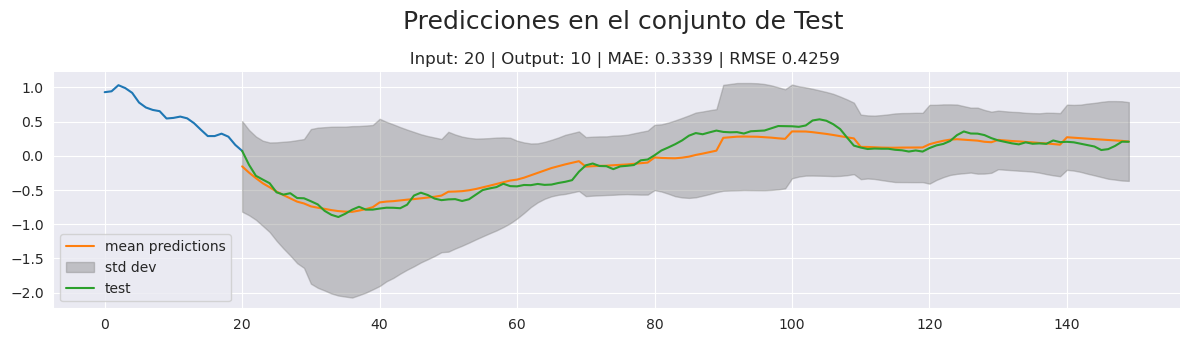

In [79]:
INPUT_SIZE = 20
OUTPUT_SIZE = 10

plt.figure(figsize=(12,3.5))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)

plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_20_10.round(4))} | RMSE {str(rmse_20_10.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media - std_dev, media + std_dev, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp20out10.png")

## Input = 30, Output = 15

In [35]:
INPUT_SIZE=30
OUTPUT_SIZE=15

In [67]:
#preds_30_15 = pd.DataFrame(columns=["input_size","output_size","mae","rmse","deep_layers","lstm_units","learning_rate","batch_size","max_epochs"])
preds_30_15 = pd.read_csv("datasets/predictions_input30_output15.csv")

In [36]:
cross_val_preds_30_15, stages_mean_30_15, mae_30_15, rmse_30_15 = cross_validation_tuning(df, 1, INPUT_SIZE, OUTPUT_SIZE, 1, 120, 0.01, 2, 300)

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 03:47:20.055066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 03:47:20.057000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 03:47:20.058404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 04:07:15.972985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 04:07:15.975059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 04:07:15.976701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 04:22:26.812235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 04:22:26.814047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 04:22:26.815432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 04:35:03.082114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 04:35:03.084371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 04:35:03.087512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 04:46:08.524316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 04:46:08.533509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 04:46:08.536774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 05:04:00.073464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 05:04:00.077110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 05:04:00.079876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 05:17:45.019838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 05:17:45.022326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 05:17:45.024029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 05:30:57.377653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 05:30:57.379590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 05:30:57.381014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 05:48:45.282954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 05:48:45.284722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 05:48:45.286304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 06:06:07.914755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 06:06:07.916810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 06:06:07.918420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 06:20:20.858074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 06:20:20.860822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 06:20:20.863979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 06:35:37.342688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 06:35:37.344732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 06:35:37.346177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 06:49:51.771662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 06:49:51.774167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 06:49:51.777191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 07:10:21.311824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 07:10:21.314195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 07:10:21.317028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 07:22:28.102419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 07:22:28.104646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 07:22:28.106612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 07:37:14.801490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 07:37:14.803220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 07:37:14.804491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 07:55:43.351098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 07:55:43.353871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 07:55:43.357277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 08:07:50.216056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 08:07:50.218993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 08:07:50.221929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 08:19:29.775804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 08:19:29.778531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 08:19:29.780729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 08:32:13.632858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 08:32:13.635775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 08:32:13.637938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (2100, 30, 4)
Dimensiones de las ventanas de salida: (2100, 15, 1)
Dimensiones de las ventanas de entrada: (105, 30, 4)
Dimensiones de las ventanas de salida: (105, 15, 1)
Dimensiones de las ventanas de entrada: (8, 30, 4)
Dimensiones de las ventanas de salida: (8, 15, 1)


2023-06-29 08:43:52.928021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 08:43:52.929906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 08:43:52.931370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [68]:
preds_30_15.sort_values(by="mae",ascending=True).head(20)

,input_size,output_size,mae,rmse,deep_layers,lstm_units,learning_rate,batch_size,max_epochs


In [37]:
INPUT_SIZE=30
OUTPUT_SIZE=15
series1 = np.array(cross_val_preds_30_15)
print(series1.shape)
media15 = np.mean(series1, axis=0)
std_dev15 = np.std(series1, axis=0)
mae_15, rmse_15 = get_metrics(stages_mean[INPUT_SIZE:], media15, False)

(21, 120)


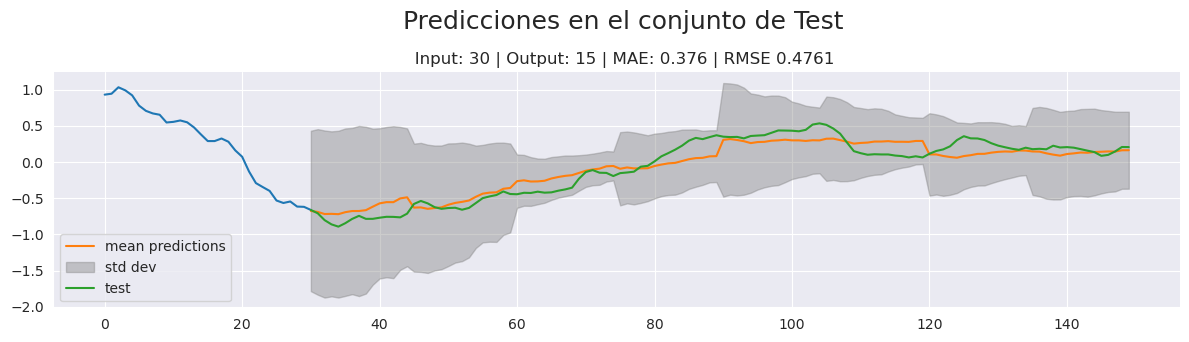

In [63]:
INPUT_SIZE = 30
OUTPUT_SIZE = 15

plt.figure(figsize=(12,6))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.subplot(2, 1, 1)

plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_20_15.round(4))} | RMSE {str(rmse_20_15.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media - std_dev, media + std_dev, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp30out15.png")

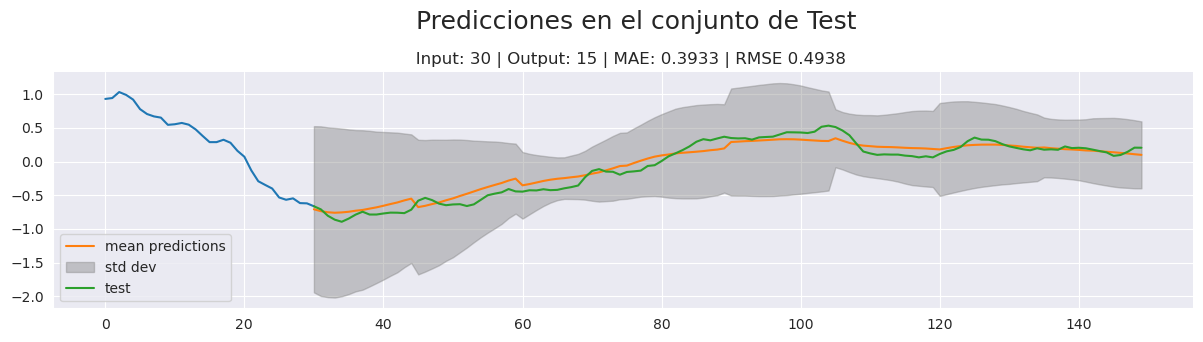

In [82]:
INPUT_SIZE = 30
OUTPUT_SIZE = 15

plt.figure(figsize=(12,6))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.subplot(2, 1, 1)

plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_20_15.round(4))} | RMSE {str(rmse_20_15.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media - std_dev, media + std_dev, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp30out15.png")

## Input = 30, Output = 20

In [64]:
INPUT_SIZE=30
OUTPUT_SIZE=20

In [20]:
#preds_30_20 = pd.DataFrame(columns=["input_size","output_size","mae","rmse","deep_layers","lstm_units","learning_rate","batch_size","max_epochs"])
preds_30_20 = pd.read_csv("datasets/predictions_input30_output20.csv")

In [56]:
cross_val_preds_30_20, stages_mean_30_20, mae_30_20, rmse_30_20 = cross_validation_tuning(df, 1, INPUT_SIZE, OUTPUT_SIZE, 1, 120, 0.01, 2, 300)

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:29:24.120685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:29:24.122394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:29:24.123692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:30:15.166149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:30:15.168051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:30:15.169522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:31:13.952236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:31:13.955110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:31:13.957565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:31:58.906412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:31:58.908232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:31:58.909921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:33:27.870878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:33:27.872677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:33:27.873985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:34:51.861466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:34:51.863065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:34:51.864477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:35:47.553124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:35:47.555015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:35:47.556414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:37:14.512232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:37:14.514032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:37:14.515451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:38:15.487341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:38:15.489227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:38:15.490674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:39:49.162206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:39:49.163833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:39:49.165158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:40:45.283185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:40:45.285255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:40:45.286988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:41:59.642393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:41:59.644398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:41:59.645921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:43:00.722593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:43:00.724030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:43:00.725114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:43:53.538066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:43:53.539890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:43:53.541836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:44:44.530478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:44:44.532171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:44:44.533513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:45:38.840709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:45:38.842568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:45:38.843980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:46:40.390627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:46:40.392344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:46:40.393741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:47:23.195538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:47:23.197149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:47:23.198622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:48:22.225739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:48:22.227664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:48:22.229228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:49:05.227974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:49:05.231648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:49:05.233535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (120, 30, 4)
Dimensiones de las ventanas de salida: (120, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)
Dimensiones de las ventanas de entrada: (6, 30, 4)
Dimensiones de las ventanas de salida: (6, 20, 1)


2023-06-25 05:50:16.197834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:50:16.200079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:50:16.201508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [65]:
series1 = np.array(cross_val_preds_30_20)
print(series1.shape)
media = np.mean(series1, axis=0)
std_dev = np.std(series1, axis=0)

(21, 120)


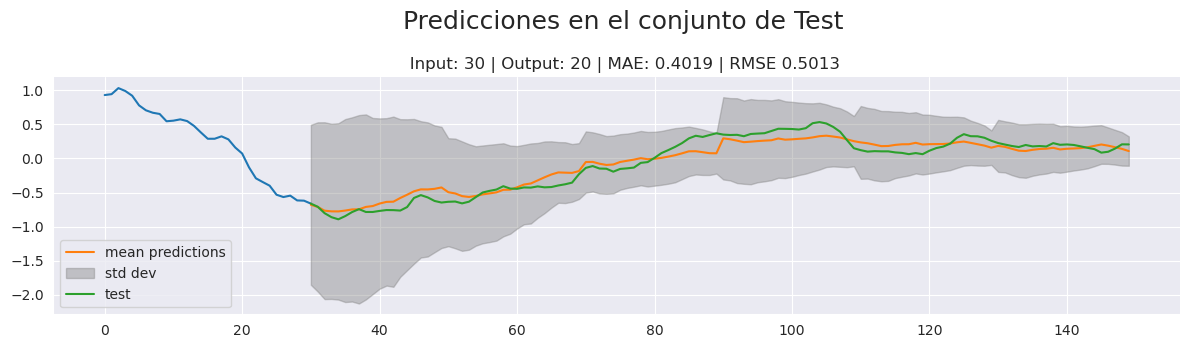

In [66]:
INPUT_SIZE = 30
OUTPUT_SIZE = 20

plt.figure(figsize=(12,3.5))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_30_20.round(4))} | RMSE {str(rmse_30_20.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean_30_20[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), (media - std_dev), (media + std_dev), color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean_30_20[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp30out20.png")

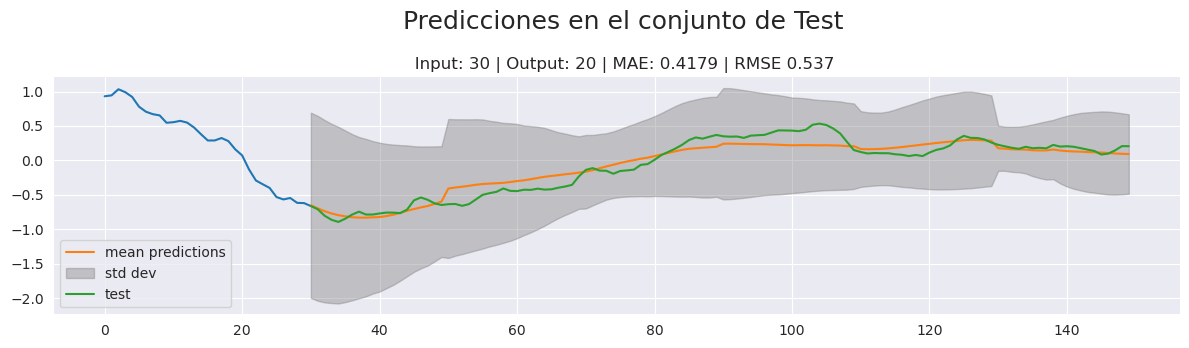

In [35]:
INPUT_SIZE = 30
OUTPUT_SIZE = 20

plt.figure(figsize=(12,3.5))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_30_20.round(4))} | RMSE {str(rmse_30_20.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean_30_20[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), (media - std_dev), (media + std_dev), color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean_30_20[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp30out20.png")

In [22]:
preds_30_20.sort_values(by="mae",ascending=True).head(20)

,input_size,output_size,mae,rmse,deep_layers,lstm_units,learning_rate,batch_size,max_epochs
39,30.0,20.0,0.215938,0.274751,0.0,80.0,0.002,1.0,300.0
61,30.0,20.0,0.218511,0.286518,0.0,120.0,0.010,2.0,300.0
35,30.0,20.0,0.221025,0.293526,0.0,80.0,0.008,4.0,300.0
219,30.0,20.0,0.221885,0.287422,2.0,120.0,0.002,1.0,300.0
94,30.0,20.0,0.223120,0.284850,1.0,60.0,0.008,2.0,300.0
33,30.0,20.0,0.224340,0.301078,0.0,80.0,0.008,1.0,300.0
20,30.0,20.0,0.224624,0.289166,0.0,60.0,0.008,4.0,300.0
137,30.0,20.0,0.225277,0.300924,1.0,120.0,0.010,4.0,300.0
112,30.0,20.0,0.226196,0.289832,1.0,80.0,0.005,2.0,300.0
95,30.0,20.0,0.226561,0.289035,1.0,60.0,0.008,4.0,300.0


## Input = 30, Output = 30

In [57]:
INPUT_SIZE=30
OUTPUT_SIZE=30

In [58]:
cross_val_preds_30_30, stages_mean_30_30, mae_30_30, rmse_30_30 = cross_validation_tuning(df, 1, INPUT_SIZE, OUTPUT_SIZE, 1, 120, 0.01, 2, 300)

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:51:27.390991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:51:27.392959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:51:27.395748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:52:00.850158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:52:00.853765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:52:00.855926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:52:58.070704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:52:58.073068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:52:58.074551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:53:48.389360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:53:48.391302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:53:48.392779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:54:31.567594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:54:31.569764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:54:31.571928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:55:01.825786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:55:01.828187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:55:01.830481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:55:41.381987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:55:41.385243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:55:41.388345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:56:47.258999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:56:47.260446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:56:47.261822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:57:20.236205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:57:20.239243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:57:20.241900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:57:56.427491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:57:56.429127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:57:56.430656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:58:34.737823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:58:34.740087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:58:34.741741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:59:11.602660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:59:11.605048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:59:11.607216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 05:59:45.279352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 05:59:45.282478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 05:59:45.284015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:00:19.594704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:00:19.596689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:00:19.598213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:01:02.547785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:01:02.549755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:01:02.551207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:01:46.671051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:01:46.673910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:01:46.676449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:02:28.355429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:02:28.357205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:02:28.358772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:03:04.155972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:03:04.159206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:03:04.160928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:03:39.033798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:03:39.035907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:03:39.037576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:04:26.366335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:04:26.368132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:04:26.369529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Dimensiones de las ventanas de entrada: (80, 30, 4)
Dimensiones de las ventanas de salida: (80, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)
Dimensiones de las ventanas de entrada: (4, 30, 4)
Dimensiones de las ventanas de salida: (4, 30, 1)


2023-06-25 06:05:06.986124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 06:05:06.988949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 06:05:06.990835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [67]:
series1 = np.array(cross_val_preds_30_30)
print(series1.shape)
media = np.mean(series1, axis=0)
std_dev = np.std(series1, axis=0)

(21, 120)


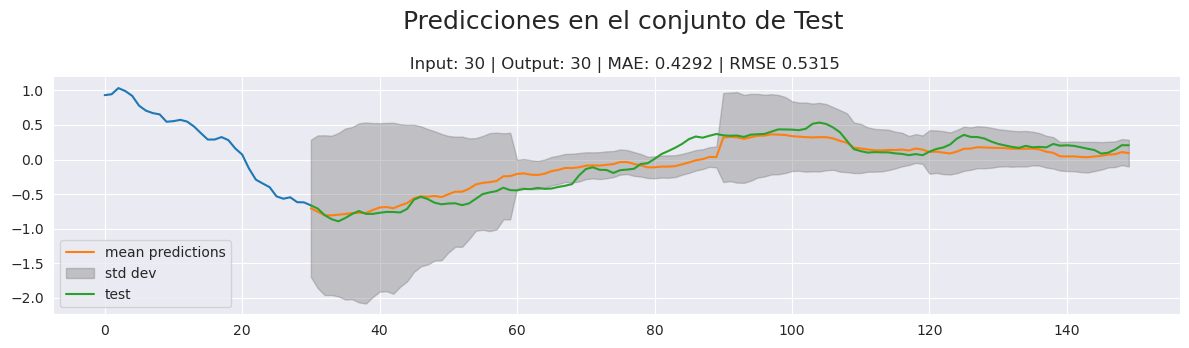

In [68]:
INPUT_SIZE = 30
OUTPUT_SIZE = 30

plt.figure(figsize=(12,3.5))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_30_30.round(4))} | RMSE {str(rmse_30_30.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean_30_30[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), (media - std_dev), (media + std_dev), color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean_30_30[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp30out30.png")

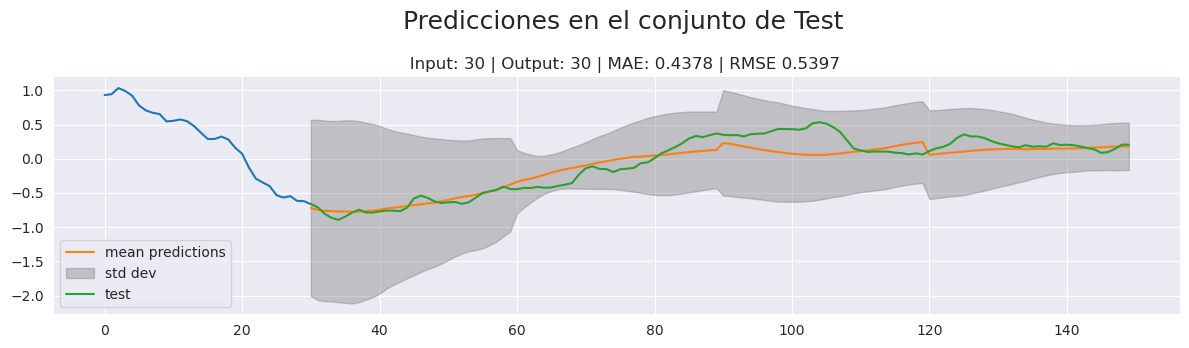

In [42]:
INPUT_SIZE = 30
OUTPUT_SIZE = 30

plt.figure(figsize=(12,3.5))
plt.suptitle('       Predicciones en el conjunto de Test',fontsize=18)
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_30_30.round(4))} | RMSE {str(rmse_30_30.round(4))}")
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean_30_30[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), (media - std_dev), (media + std_dev), color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean_30_30[INPUT_SIZE:STAGES_LENGTH].values), label="test")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/cross_val_inp30out30.png")

## Graphics Together

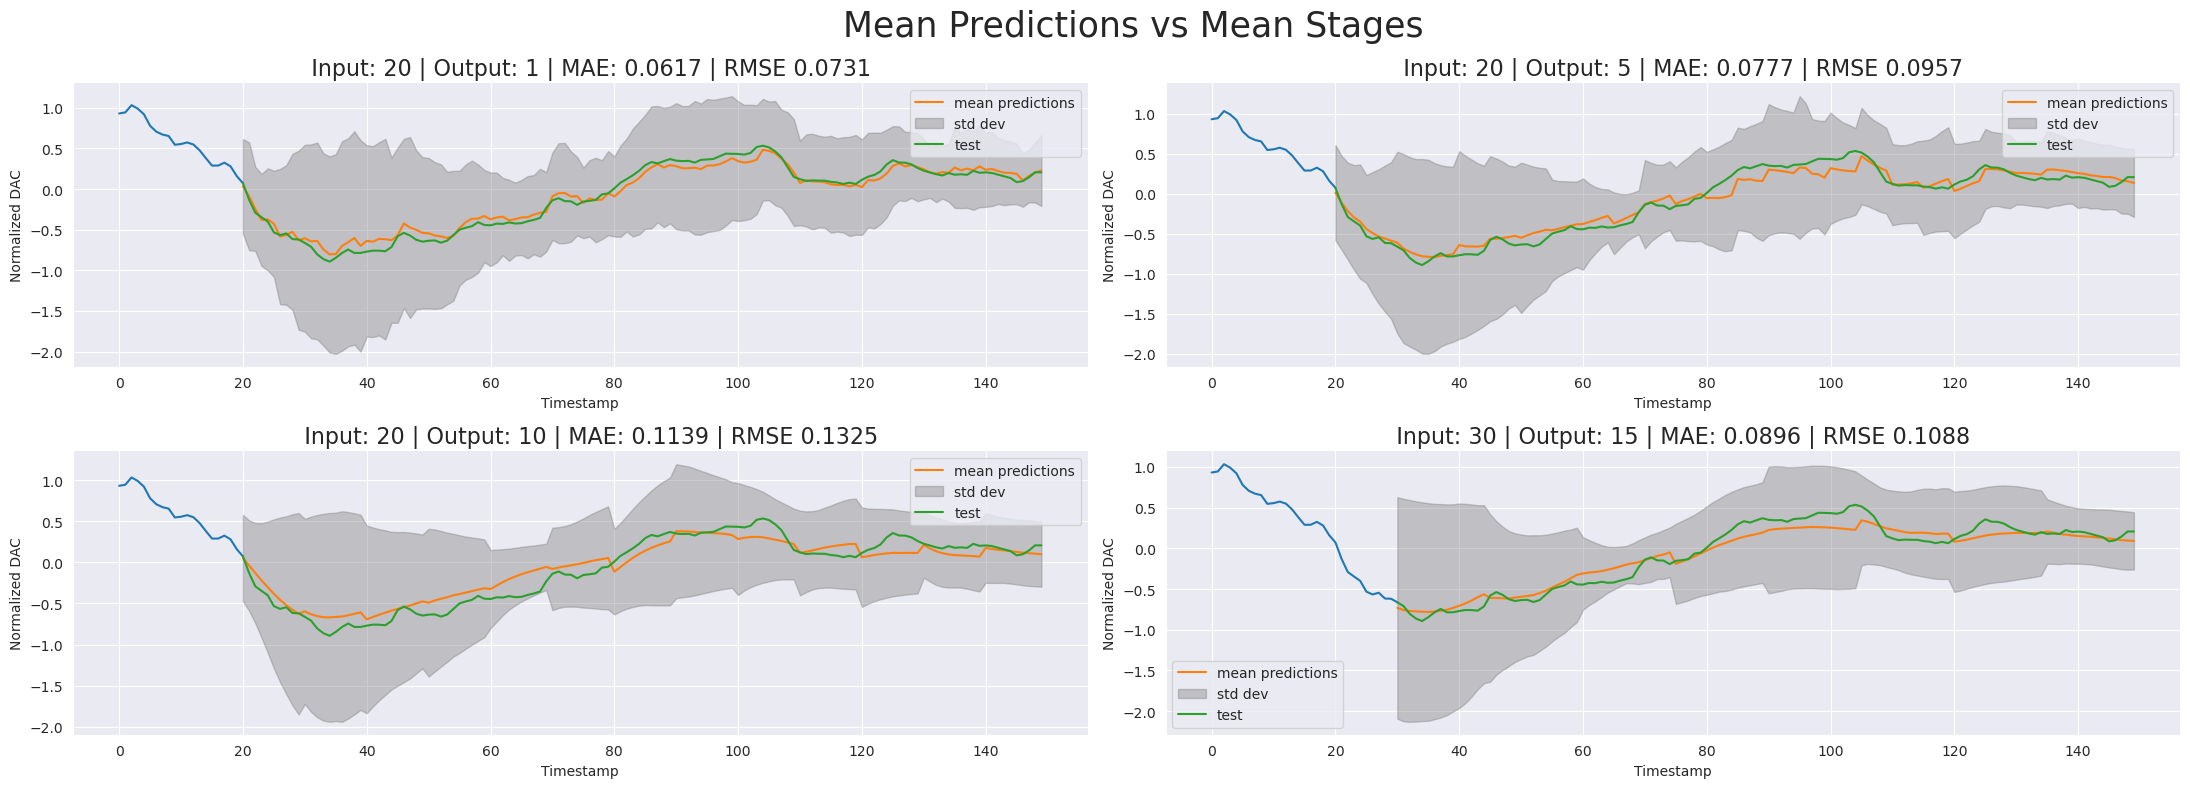

In [41]:
plt.figure(figsize=(22,8))
plt.suptitle('       Mean Predictions vs Mean Stages',fontsize=25)
plt.subplot(2, 2, 1)

INPUT_SIZE = 20
OUTPUT_SIZE = 1
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae.round(4))} | RMSE {str(rmse.round(4))}",fontsize=16)
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media - std_dev, media + std_dev, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
plt.xlabel("Timestamp")
plt.ylabel("Normalized DAC")
sns.set_style("darkgrid")

sns.despine()


plt.subplot(2, 2, 2)

INPUT_SIZE = 20
OUTPUT_SIZE = 5
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_5.round(4))} | RMSE {str(rmse_5.round(4))}",fontsize=16)
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media5), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media5 - std_dev5, media5 + std_dev5, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
plt.xlabel("Timestamp")
plt.ylabel("Normalized DAC")
sns.set_style("darkgrid")

sns.despine()


plt.subplot(2, 2, 3)

INPUT_SIZE = 20
OUTPUT_SIZE = 10
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_10.round(4))} | RMSE {str(rmse_10.round(4))}",fontsize=16)
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media10), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media10 - std_dev10, media10 + std_dev10, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
plt.xlabel("Timestamp")
plt.ylabel("Normalized DAC")
sns.set_style("darkgrid")

sns.despine()


plt.subplot(2, 2, 4)

INPUT_SIZE = 30
OUTPUT_SIZE = 15
plt.title(f"   Input: {str(INPUT_SIZE)} | Output: {str(OUTPUT_SIZE)} | MAE: {str(mae_15.round(4))} | RMSE {str(rmse_15.round(4))}",fontsize=16)
sns.lineplot(x=range(0,INPUT_SIZE+1),y=pd.Series(stages_mean[:INPUT_SIZE+1].values))
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH), y=pd.Series(media15), label="mean predictions")
plt.fill_between(range(INPUT_SIZE,STAGES_LENGTH), media15 - std_dev15, media15 + std_dev15, color='grey', alpha=0.4, label='std dev')
sns.lineplot(x=range(INPUT_SIZE,STAGES_LENGTH),y=pd.Series(stages_mean[INPUT_SIZE:STAGES_LENGTH].values), label="test")
plt.xlabel("Timestamp")
plt.ylabel("Normalized DAC")
sns.set_style("darkgrid")

sns.despine()

plt.tight_layout()

#plt.savefig("mov_win/all_crossval.png")